In [1]:
import pandas as pd
from datetime import date
import numpy as np
from matplotlib import pyplot as plt
import pymongo
from pymongo import MongoClient
import json
import seaborn as sns
import plotly.express as px

# Get All that Data!!
## from my Scrapping 

In [2]:
connection_params = json.load(open('conn_params.txt'))

In [3]:
def connect(connection_params):
    connection = MongoClient('mongodb://{user}:{password}@{host}/{namespace}'.format(**connection_params),retryWrites=False)
    db = connection.covid19chile
    return db


In [4]:
db = connect(connection_params).covidchile

In [5]:
df = pd.DataFrame(list(db.find()))

In [6]:
df.head()

_id Country,Other TotalCases NewCases TotalDeaths  \
0  5e8d05e21fd1a68f1358585b       Austria      12297     +246         220   
1  5e8d05e21fd1a68f1358585c        Canada      16666    +1154         323   
2  5e8d05e21fd1a68f1358585d   Netherlands      18803     +952        1867   
3  5e8d05e21fd1a68f1358585e       Belgium      20814    +1123        1632   
4  5e8d05e21fd1a68f1358585f   Switzerland      21657     +557         765   

  NewDeaths TotalRecovered ActiveCases Serious,Critical TotCases/1M pop  \
0       +16           3463        8614              250            1365   
1       +43           3534       12809              426             442   
2      +101            250       16686             1409            1097   
3      +185           3986       15196             1257            1796   
4       +50           8056       12836              391            2502   

  Deaths/1M pop TotalTests Tests/\n1M pop       date TotDeaths/1M pop 1stcase  \
0            24     111296          12357 2020-04-07              NaN     NaN   
1             9     330901           8767 2020-04-07              NaN     NaN   
2           109      86589           5053 2020-04-07              NaN     NaN   
3           141      70000           6040 2020-04-07              NaN     NaN   
4            88     162500          18776 2020-04-07              NaN     NaN   

  Reported1st case  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [7]:
len(df.groupby('Country,Other').count().index)

218

# Get world population 

In [8]:
world_pop = pd.read_csv('WorldPopulation.csv')

In [9]:
world_pop.head()

# Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0  235                Holy See                801        0.25 %           2   
1  234                 Tokelau               1357        1.27 %          17   
2  233                    Niue               1626        0.68 %          11   
3  232        Falkland Islands               3480        3.05 %         103   
4  231              Montserrat               4992        0.06 %           3   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0             2003                0             NaN       N.A.     N.A.   
1              136               10             NaN       N.A.     N.A.   
2                6              260             NaN       N.A.     N.A.   
3                0            12170             NaN       N.A.     N.A.   
4               50              100             NaN       N.A.     N.A.   

  Urban Pop % World Share  
0        N.A.      0.00 %  
1         0 %      0.00 %  
2        46 %      0.00 %  
3        66 %      0.00 %  
4        10 %      0.00 %

In [10]:
df_w = world_pop[['Country (or dependency)','Population (2020)']]

In [11]:
df_w = df_w.replace('United States', 'USA')

### Merge World Population

In [57]:
data = pd.merge(df, df_w, how='left', left_on='Country,Other', right_on='Country (or dependency)').drop('Country (or dependency)', axis = 1)

In [58]:
#data = data.set_index('date')

In [59]:
cols=[i for i in data.columns if i not in ["_id","Country,Other","1stcase","Reported1st case","date"]]
for col in cols:
    print(col)
    data[col] = data[col].replace('-', '', regex=True)
    data[col] = data[col].replace(r'^\s*$', np.nan, regex=True)
    data[col] = data[col].astype(float)


TotalCases
NewCases
TotalDeaths
NewDeaths
TotalRecovered
ActiveCases
Serious,Critical
TotCases/1M pop
Deaths/1M pop
TotalTests
Tests/
1M pop
TotDeaths/1M pop
Population (2020)


In [60]:
data['TotalCases/Tot Population'] = data['TotalCases']/data['Population (2020)']

# Get Top COuntries

In [162]:
countries = data.groupby('Country,Other').sum().sort_values(by='TotalCases', ascending=False)[15:40].index[2:]

In [163]:
countries

Index(['Portugal', 'Brazil', 'Israel', 'Norway', 'Sweden', 'Australia',
       'Denmark', 'Czechia', 'Ireland', 'Malaysia', 'Russia', 'Chile', 'Japan',
       'Poland', 'Ecuador', 'Romania', 'Pakistan', 'Luxembourg', 'India',
       'Philippines', 'Saudi Arabia', 'Thailand', 'Indonesia'],
      dtype='object', name='Country,Other')

In [164]:
top_data = data[data['Country,Other'].isin(countries)]

In [165]:
grouped_country = top_data.groupby(['Country,Other','date']).sum()

In [166]:
grouped_country_not_0 = grouped_country[grouped_country['TotalCases']>0]

In [167]:
list_by_country = grouped_country_not_0.groupby('Country,Other').aggregate(list)

In [168]:
filtered_by_len = list_by_country[list_by_country['TotCases/1M pop'].map(len) > 7]

In [176]:
interes_column = ['TotalCases', 'NewCases','TotalDeaths','NewDeaths',
'TotalRecovered',
'ActiveCases',
'Serious,Critical',
'TotCases/1M pop',
'Deaths/1M pop',
'TotalTests',
'Tests/\n1M pop',
'TotDeaths/1M pop']

In [177]:
max(list_by_country['TotalCases'].map(len))

40

In [171]:
max_val = 40

In [179]:
all_data = []
all_labels = []

In [180]:
for col in interes_column:
    data_to_cluster = list(map(lambda x: list(np.pad(np.array(x), (max_val-len(x))//2)), list_by_country[col].values))
    for i, element in enumerate(data_to_cluster):
        if len(element) < max_val:
            data_to_cluster[i].append(0)
    labels = list(list_by_country[col].index)
    all_data+=data_to_cluster
    print(len(all_data), len(data_to_cluster))
    all_labels+=labels                   

23 23
46 23
69 23
92 23
115 23
138 23
161 23
184 23
207 23
230 23
253 23
276 23


In [ ]:
data_to_cluster = list(map(lambda x: list(np.pad(np.array(x), (39-len(x))//2), list_by_country.values))

In [109]:
data_to_cluster = np.array(list(map(lambda x: np.pad(np.array(x), 41-len(x)//2), filtered_by_len['TotCases/1M pop'].values)))

In [39]:
for i, element in enumerate(data_to_cluster):
    if len(element) < 40:
        data_to_cluster[i].append(0)

In [40]:
data_to_cluster = np.array(data_to_cluster)

In [41]:
labels = filtered_by_len['TotCases/1M pop'].index

In [186]:

from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_result = pca.fit_transform(np.array(all_data))



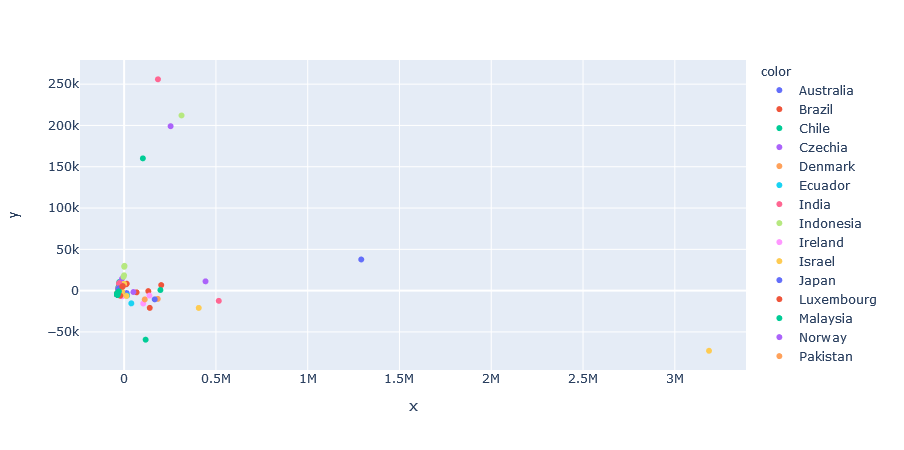

In [187]:
sns.set(rc={'figure.figsize':(15,15)})
fig = px.scatter(x=pca_result[:,0], y=pca_result[:,1], color=all_labels)
fig.show()


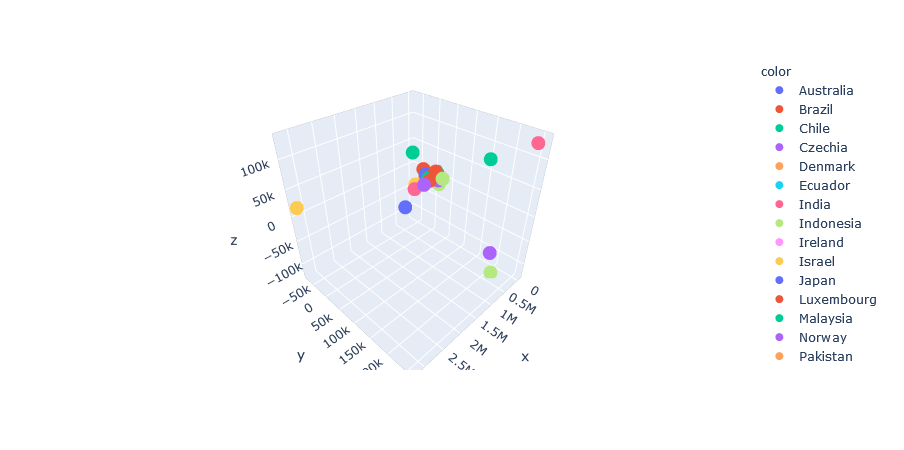

In [188]:
fig = px.scatter_3d(x=pca_result[:,0], y=pca_result[:,1], z=pca_result[:,2],
              color=all_labels)
fig.show()

In [189]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(np.array(all_data))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 276 samples in 0.000s...
[t-SNE] Computed neighbors for 276 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 276 / 276
[t-SNE] Mean sigma: 15.835160
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.720592
[t-SNE] KL divergence after 1000 iterations: 0.152767


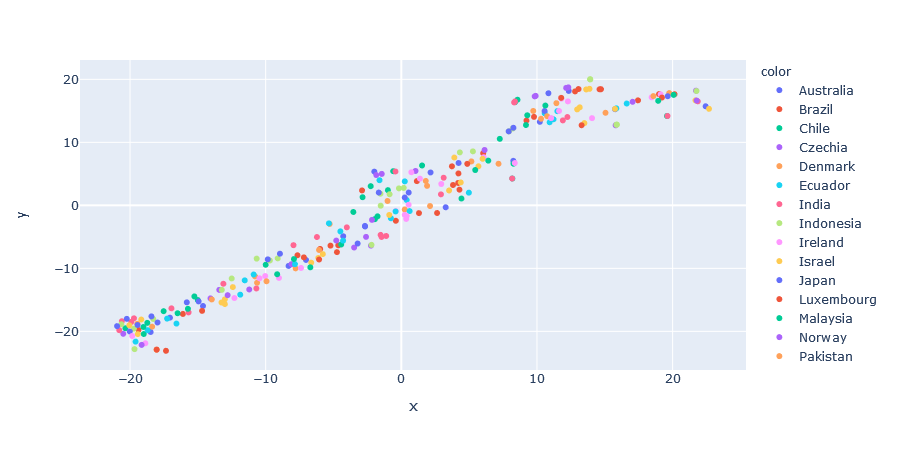

In [190]:
sns.set(rc={'figure.figsize':(15,15)})
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], color=all_labels)
fig.show()


C:\Users\Angeles\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



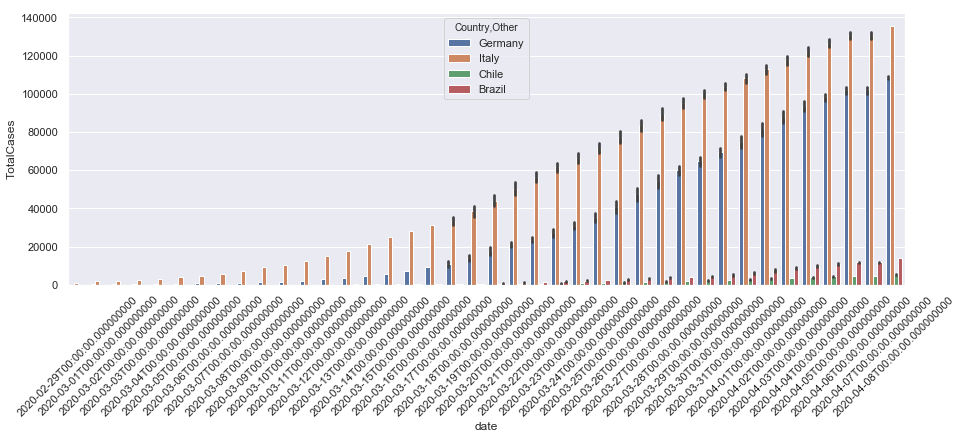

In [70]:
plt.figure(figsize=(15,5))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalCases', hue='Country,Other', data=data[(data['Country,Other']=='Chile') | (data['Country,Other']=='Italy')| (data['Country,Other']=='Germany') | (data['Country,Other']=='Brazil')])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

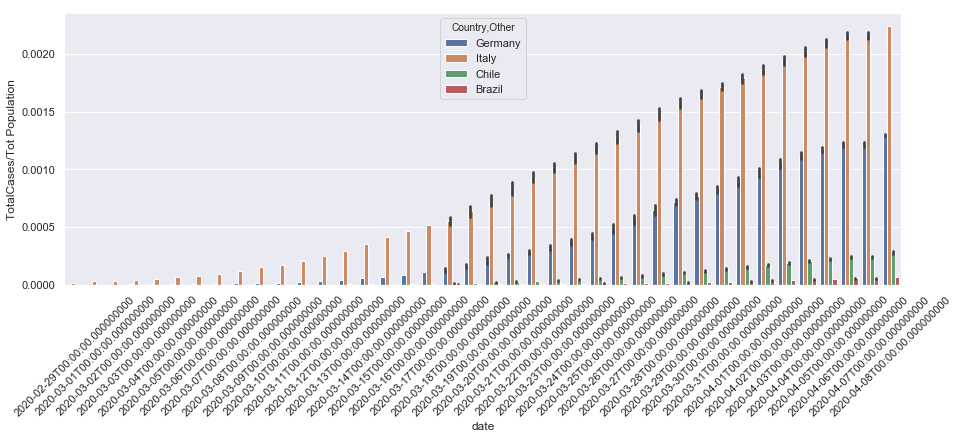

In [71]:
plt.figure(figsize=(15,5))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalCases/Tot Population', hue='Country,Other', data=data[(data['Country,Other']=='Chile') | (data['Country,Other']=='Italy')| (data['Country,Other']=='Germany') | (data['Country,Other']=='Brazil')])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

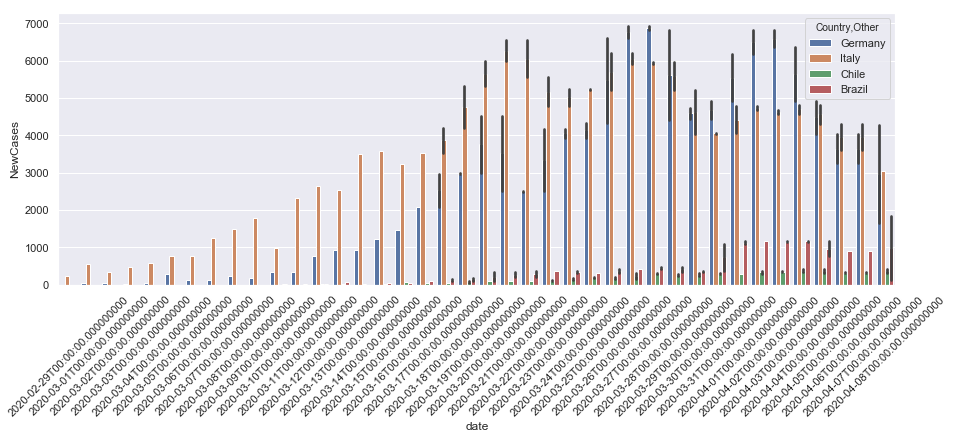

In [72]:
plt.figure(figsize=(15,5))
# Plot the barplot
chart = sns.barplot(x='date', y='NewCases', hue='Country,Other', data=data[(data['Country,Other']=='Chile') | (data['Country,Other']=='Italy')| (data['Country,Other']=='Germany') | (data['Country,Other']=='Brazil')])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

In [200]:
countries_on_interest = ['Chile','Italy','Germany','Brazil']

In [202]:
group = data.groupby(['Country,Other','date']).sum().loc[:, interes_column].diff().loc[countries_on_interest]

In [209]:
group = group.reset_index()

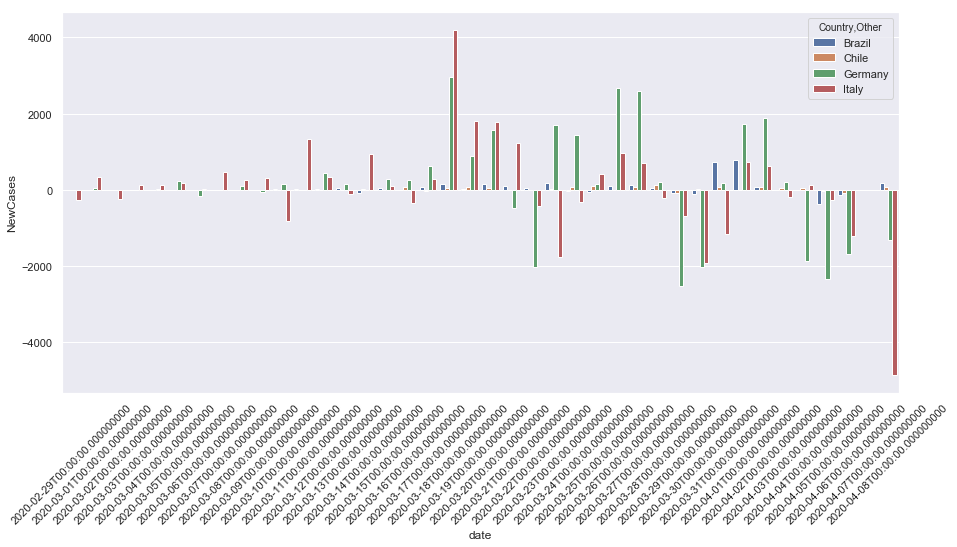

In [212]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='NewCases', hue='Country,Other', data=group)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

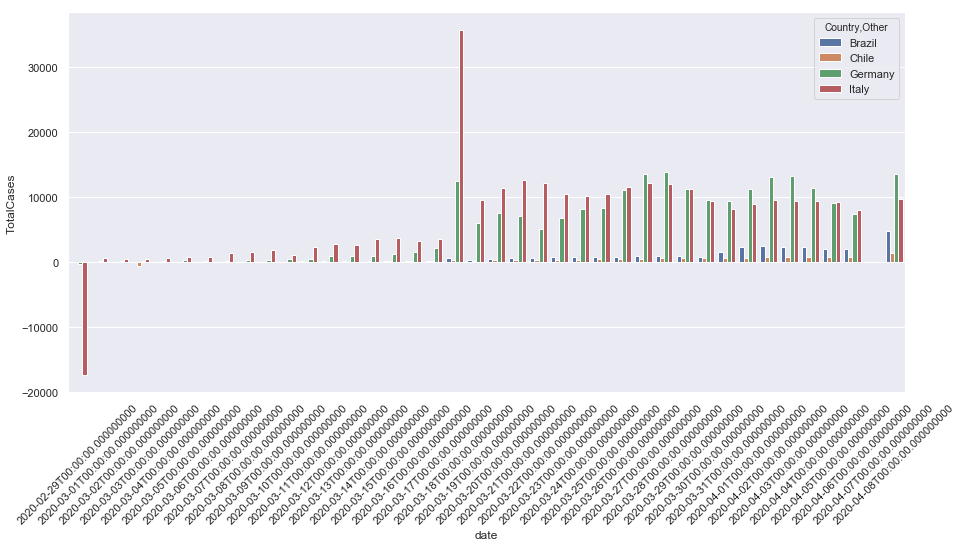

In [213]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalCases', hue='Country,Other', data=group)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

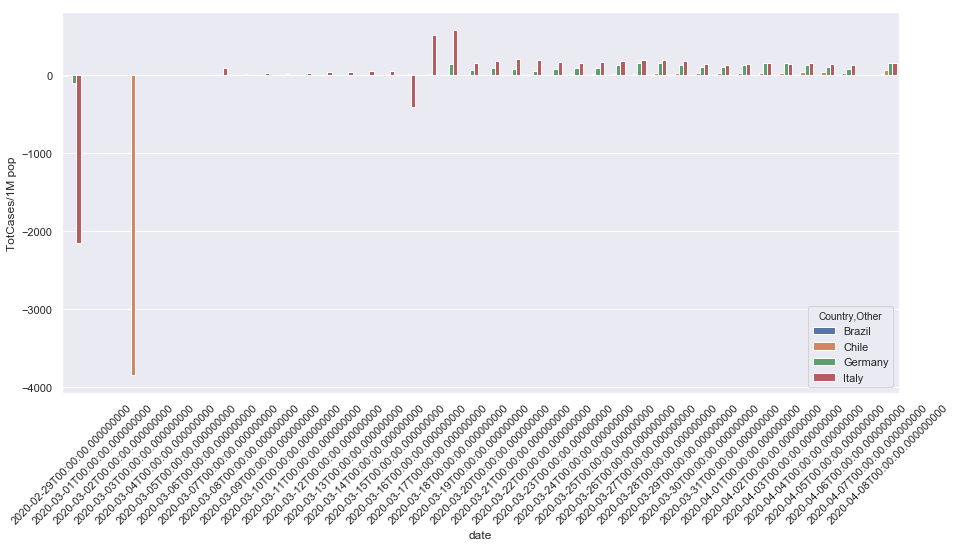

In [214]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='TotCases/1M pop', hue='Country,Other', data=group)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

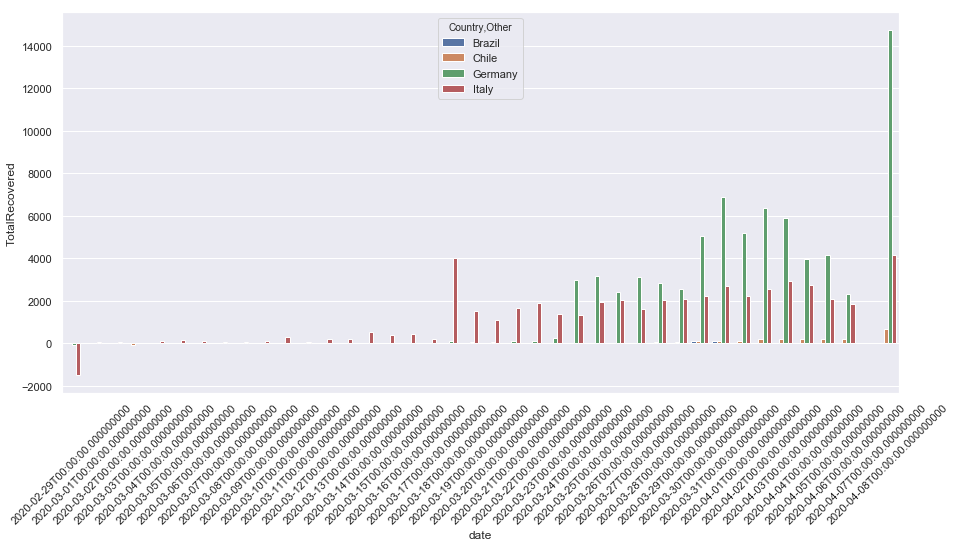

In [216]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalRecovered', hue='Country,Other', data=group)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

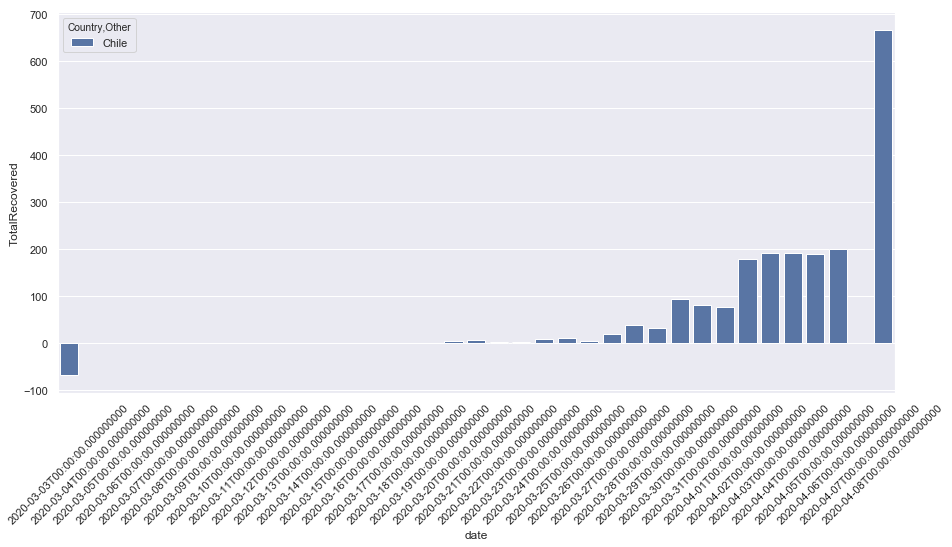

In [217]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalRecovered', hue='Country,Other', data=group[group['Country,Other']=='Chile'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

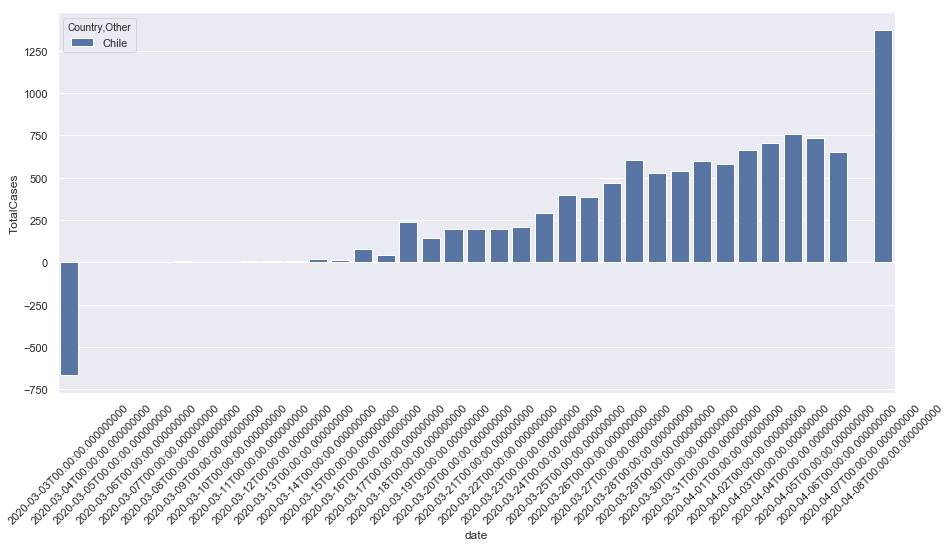

In [218]:
plt.figure(figsize=(15,7))
# Plot the barplot
chart = sns.barplot(x='date', y='TotalCases', hue='Country,Other', data=group[group['Country,Other']=='Chile'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart